In [1]:
import torch
import MiniFL as mfl

In [2]:
from sklearn.datasets import load_svmlight_file
from copy import deepcopy

NUM_CLIENTS = 20

data, labels = load_svmlight_file("phishing.txt")
enc_labels = labels.copy()
data_dense = data.todense()


eval_data = (torch.from_numpy(data_dense).to(torch.float32), torch.from_numpy(enc_labels).to(torch.float32)[:, None])
partition_size = (len(eval_data[0]) - 1) // NUM_CLIENTS + 1
clients_data = [(x, y) for x, y in zip(torch.split(eval_data[0], partition_size, dim=0), torch.split(eval_data[1], partition_size, dim=0))]

NETWORK= torch.nn.Linear(eval_data[0].shape[1],1, bias=False)
LOSS = torch.nn.BCEWithLogitsLoss()

In [3]:
from tqdm import trange

def run_client(i:int, client: mfl.algorithms.gd.GDClient):
    client.prepare()
    for _ in range(100):
        _ = client.step()
        
def run_master(master: mfl.algorithms.gd.GDMaster, metrics: list):
    master.prepare()
    for i in trange(100):
        master_metrics = master.step()
        metrics.append(master_metrics)

In [4]:
GD_METRICS = []

master_fn = mfl.fn.NNDifferentiableFn(
    model=deepcopy(NETWORK),
    data=eval_data,
    loss_fn=LOSS,
    batch_size=-1,
    seed=0,
)

client_fns = [mfl.fn.NNDifferentiableFn(
    model=deepcopy(NETWORK),
    data=clients_data[i],
    loss_fn=LOSS,
    batch_size=-1,
    seed=i,
) for i in range(NUM_CLIENTS)]

master, clients = mfl.algorithms.get_gd_master_and_clients(
    master_fn=master_fn,
    client_fns=client_fns,
    gamma=1,
    # rand_p=0.2,
    # top_p=0.2,
    # p=0.01,
)

import threading

client_threads = []
for i, client in enumerate(clients):
    client_threads.append(threading.Thread(target=run_client, args=(i, client)))
    client_threads[-1].start()
    
master_thread = threading.Thread(target=run_master, args=(master, GD_METRICS))
master_thread.start()

master_thread.join()
for t in client_threads:
    t.join()

100%|██████████| 100/100 [00:03<00:00, 31.91it/s]


In [5]:
MARINA_METRICS = []

master_fn = mfl.fn.NNDifferentiableFn(
    model=deepcopy(NETWORK),
    data=eval_data,
    loss_fn=LOSS,
    batch_size=-1,
    seed=0,
)

client_fns = [mfl.fn.NNDifferentiableFn(
    model=deepcopy(NETWORK),
    data=clients_data[i],
    loss_fn=LOSS,
    batch_size=-1,
    seed=i,
) for i in range(NUM_CLIENTS)]

master, clients = mfl.algorithms.get_permk_marina_master_and_clients(
    master_fn=master_fn,
    client_fns=client_fns,
    gamma=1,
    # rand_p=0.2,
    # top_p=0.2,
    p=0.1,
)

import threading

client_threads = []
for i, client in enumerate(clients):
    client_threads.append(threading.Thread(target=run_client, args=(i, client)))
    client_threads[-1].start()
    
master_thread = threading.Thread(target=run_master, args=(master, MARINA_METRICS))
master_thread.start()

master_thread.join()
for t in client_threads:
    t.join()
    


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:04<00:00, 20.55it/s]


In [6]:
COCKTAIL_METRICS = []

master_fn = mfl.fn.NNDifferentiableFn(
    model=deepcopy(NETWORK),
    data=eval_data,
    loss_fn=LOSS,
    batch_size=-1,
    seed=0,
)

client_fns = [mfl.fn.NNDifferentiableFn(
    model=deepcopy(NETWORK),
    data=clients_data[i],
    loss_fn=LOSS,
    batch_size=-1,
    seed=i,
) for i in range(NUM_CLIENTS)]

master, clients = mfl.algorithms.get_cocktailgd_master_and_clients(
    master_fn=master_fn,
    client_fns=client_fns,
    gamma=1,
    rand_p=0.2,
    top_p=0.2,
    # p=0.1,
)

import threading

client_threads = []
for i, client in enumerate(clients):
    client_threads.append(threading.Thread(target=run_client, args=(i, client)))
    client_threads[-1].start()
    
master_thread = threading.Thread(target=run_master, args=(master, COCKTAIL_METRICS))
master_thread.start()

master_thread.join()
for t in client_threads:
    t.join()
    


100%|██████████| 100/100 [00:07<00:00, 13.20it/s]


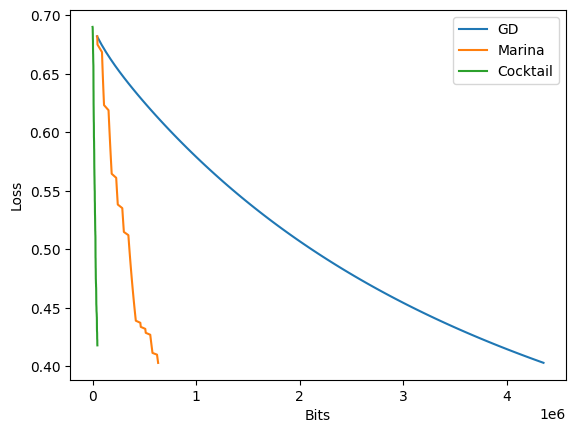

In [7]:
import matplotlib.pyplot as plt

plt.plot([metrics.total_bits_received for metrics in GD_METRICS], [metrics.value for metrics in GD_METRICS], label="GD")
plt.plot([metrics.total_bits_received for metrics in MARINA_METRICS], [metrics.value for metrics in MARINA_METRICS], label="Marina")
plt.plot([metrics.total_bits_received for metrics in COCKTAIL_METRICS], [metrics.value for metrics in COCKTAIL_METRICS], label="Cocktail")

plt.xlabel("Bits")
plt.ylabel("Loss")
plt.legend()

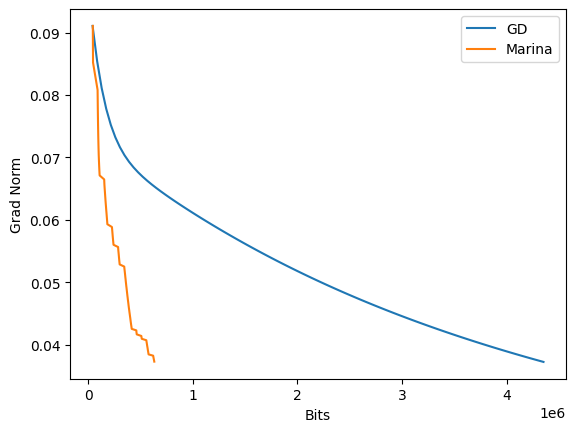

In [10]:
import matplotlib.pyplot as plt

plt.plot([metrics.total_bits_received for metrics in GD_METRICS], [metrics.grad_norm for metrics in GD_METRICS], label="GD")
plt.plot([metrics.total_bits_received for metrics in MARINA_METRICS], [metrics.grad_norm for metrics in MARINA_METRICS], label="Marina")
# plt.plot([metrics.total_bits_received for metrics in COCKTAIL_METRICS], [metrics.grad_norm for metrics in COCKTAIL_METRICS], label="Cocktail")

plt.xlabel("Bits")
plt.ylabel("Grad Norm")
plt.legend()